 # Tutorial for Gromov-Wassserstein unsupervised alignment 

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

# Step1: Prepare dissimilarity matrices or embeddings from the data
First, you need to prepare dissimilarity matrices or embeddings from your data.  
To store dissimilarity matrices or embeddings, an instance of the class `Representation` is used.   
Please put your dissimilarity matrices or embeddings into the variables `sim_mat` or `embedding` in this instance.   

## Load data
`DNN`: Latent variables from vision DNNs (ResNet50 and VGG19) for a subset of ImageNet

In [2]:
# list of representations where the instances of "Representation" class are included
representations = list()
data_select = "DNN"

### Dataset `DNN`
The latent features of two vision DNNs(Deep Neural Network), ResNet50 and VGG19, are extracted.   
The number of image used for this is 1000 (= 20 class * 50 images), subsampled from the validation set of ImageNet.  

In [3]:
### define the category info from label data in the validation dataset.
lab_path = '../../data/DNN/label.pt'
lab = torch.load(lab_path, weights_only=False).numpy()

### category_mat needs to be an one-hot encoding. 
category_mat = pd.get_dummies(lab)

category_mat.columns = np.load('../../data/DNN/label_name.npy')

from src.utils.utils_functions import get_category_data, sort_matrix_with_categories 
object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat = category_mat)

model_name_list = ['ResNet50', 'VGG19']

for model_name in model_name_list:
    
    emb_path = f'../../data/DNN/{model_name}_emb.pt'
    cos_path = f'../../data/DNN/{model_name}_cosine.pt'
    
    emb = torch.load(emb_path, weights_only=False).numpy()
    sim_mat = torch.load(cos_path, weights_only=False).numpy()
    
    ### caution!! : If your data are loaded from GPU when using torch.load() before computing `gw_alignment`, the computation may not work properly.
    ## You can solve this problem by saving the your data in CPU, like torch.save('your_data'.to("cpu")).

    model_rep = Representation(
        name=model_name, 
        sim_mat=sim_mat, 
        embedding=emb, 
        get_embedding=False,
        object_labels=object_labels,
        category_name_list=category_name_list,
        category_idx_list=category_idx_list,
        num_category_list=num_category_list, 
        func_for_sort_sim_mat=sort_matrix_with_categories,
    )

    representations.append(model_rep)
    

# Step 2: Set the parameters for the optimazation of GWOT
Second, you need to set the parameters for the optimization of GWOT.    
For most of the parameters, you can start with the default values.   
However, there are some essential parameters that you need to check for your original applications.  

## Optimization Config  

#### Most important parameters to check for your application:
`eps_list`: The range of the values of epsilon for entropic GWOT.   
If epsilon is not in appropriate ranges (if it is too low), the optimization may not work properly.   
Although the algorithm will find good epsilon values after many trials, it is a good practice to narrow down the range beforehand.   

`num_trial`: The number of trials to test epsilon values from the specified range.   
This number directly determines the quality of the unsupervised alignment.   
You should set this number high enough to find good local minima. 

In [4]:
eps_list_tutorial = [1e-4, 1e-2]
device = 'cuda' # 'cpu' if GPU is not available
to_types = 'torch' # 'numpy'

# whether epsilon is sampled at log scale or not
eps_log = True
num_trial = 10

init_mat_plan = "random" # "uniform" or "random"

In [5]:
if device == 'cuda':
    sinkhorn_method = 'sinkhorn_log' # please choose the method of sinkhorn implemented by POT (URL : https://pythonot.github.io/gen_modules/ot.bregman.html#id87). For using GPU, "sinkhorn_log" is recommended.
    data_type= 'double'
    multi_gpu = False 

elif device == 'cpu':
    sinkhorn_method = 'sinkhorn'
    data_type = 'double'
    multi_gpu = True

In [6]:
config = OptimizationConfig(    
    eps_list = eps_list_tutorial,
    eps_log = eps_log, 
    num_trial = num_trial,
    sinkhorn_method=sinkhorn_method, # please choose the method of sinkhorn implemented by POT (URL : https://pythonot.github.io/gen_modules/ot.bregman.html#id87). For using GPU, "sinkhorn_log" is recommended.
    
    ### Set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
    to_types = to_types,
    device = device,
    data_type = data_type, 
    
    n_jobs = 1,
    multi_gpu = multi_gpu, 
    db_params={"drivername": "sqlite"},
    # db_params={"drivername": "mysql+pymysql", "username": "root", "password": "****", "host": "localhost"},
    
    init_mat_plan = init_mat_plan,
    
    n_iter = 1,
    max_iter = 200,
    
    sampler_name = 'tpe',
    pruner_name = 'hyperband',
    pruner_params = {'n_startup_trials': 1, 
                     'n_warmup_steps': 2, 
                     'min_resource': 2, 
                     'reduction_factor' : 3
                    },
)

## Step 3 : Gromov-Wasserstein Optimal Transport (GWOT) between Representations
Third, you perform GWOT between the instanses of "Representation", by using the class `AlignRepresentations`.  
This class has methods for the optimization of entropic Gromov-Wasserstein distance, and the evaluation of the GWOT (Step 4).  
This class also has a method to perform conventional Representation Similarity Analysis (RSA).   

--- 
## Directory for saving the results of GWOT

Here is the directory structure to save the results below.  

```
    main_results_dir (= data_name (e.g. `THINGS`)) /
        ├─ data_name + pair_name (e.g. `THINGS_Group1_vs_Group2`) /
        │    ├─ initial_transportation_plan_name (e.g. `random`) /
        │        ├─ figure /
        │        │   ├─ some figures (e.g. acc_gwd_eps.png)
        │        ├─ data /
        │        │   ├─ OT.npy (numpy) or OT.pt (torch)
        │        │   
        │        ├─ database (if using sqlite; e.g. `THINGS_Group1_vs_Group2_random.db`)
        │
        ├─ visualize_embedding/ 
        │    ├─ initial_transportation_plan_name (e.g. `random`) /
        │            ├─  some figures(e.g. `Aligned_embedding.png`; made by running `align_representation.visualize_embedding`. Please see the bottom of this notebook) 
        │
        ├─ individual_sim_mat (e.g. `RDM_Group1.png`) /
                ├─ initial_transportation_plan_name (e.g. `random`) /
                        ├─  some figures(e.g. `RDM_Group1.png`) 
        
``` 

- This folder structure will be automatically made in the process of GWOT optimization.
- You can provide the names of the save folders by changing the following variables: `main_result_dir`,  `data_name`, and `pair_name`(defined by the two `representations.name`). 

In [7]:
# Create an "AlignRepresentations" instance
align_representation = AlignRepresentations(
    config=config,
    representations_list=representations,   
   
    # histogram matching : this will adjust the histogram of target to that of source.
    histogram_matching=False,

    # metric : The metric for computing the distance between the embeddings. Please set the metric tha can be used in "scipy.spatical.distance.cdist()".
    metric="cosine", 

    # main_results_dir : folder or file name when saving the result
    main_results_dir =  "../../results/" + data_select,
   
    # data_name : Please rewrite this name if users want to use their own data.
    data_name = data_select,
)

data_name : DNN
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: ResNet50_vs_VGG19 eps_list: [0.0001, 0.01]


## Show dissimilarity matrices

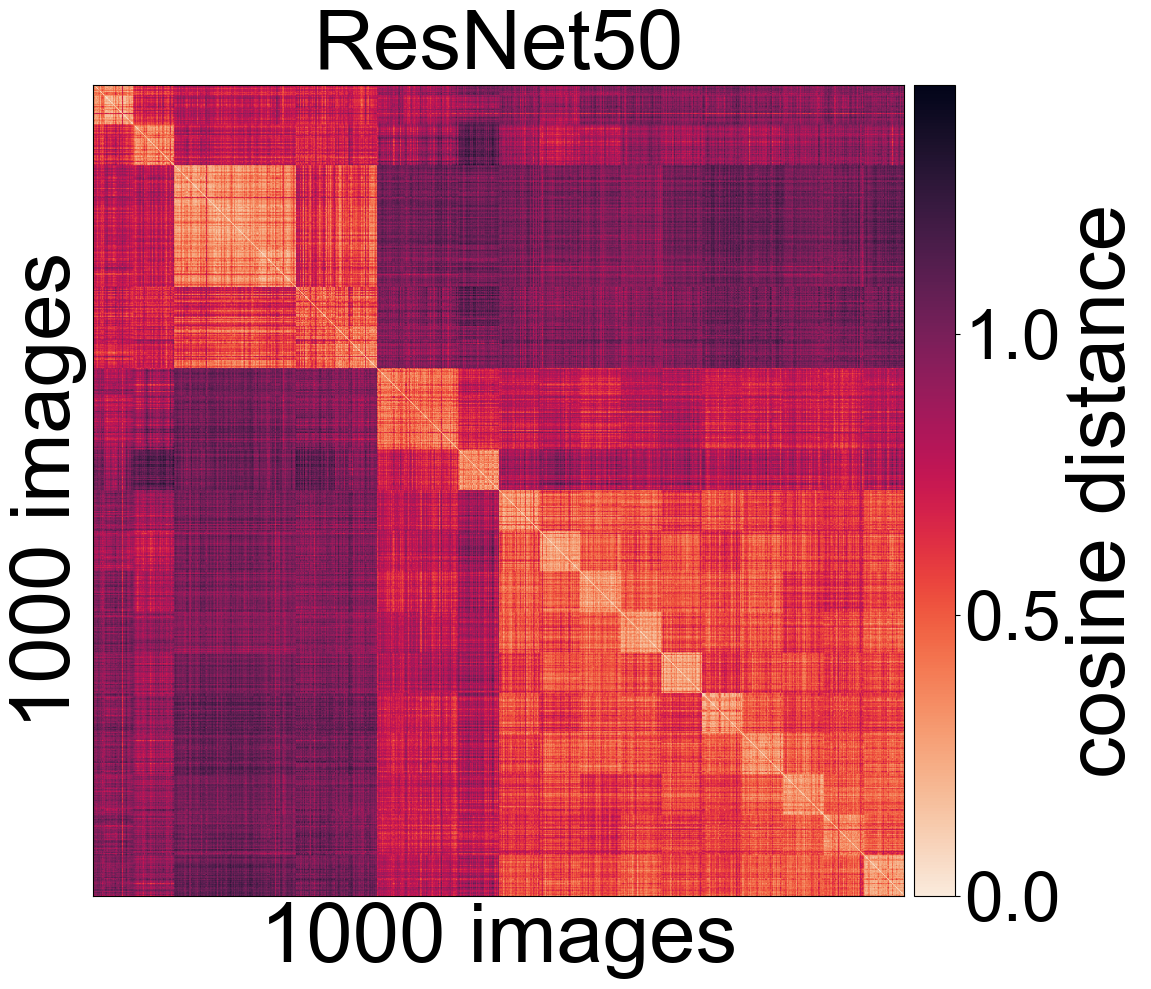

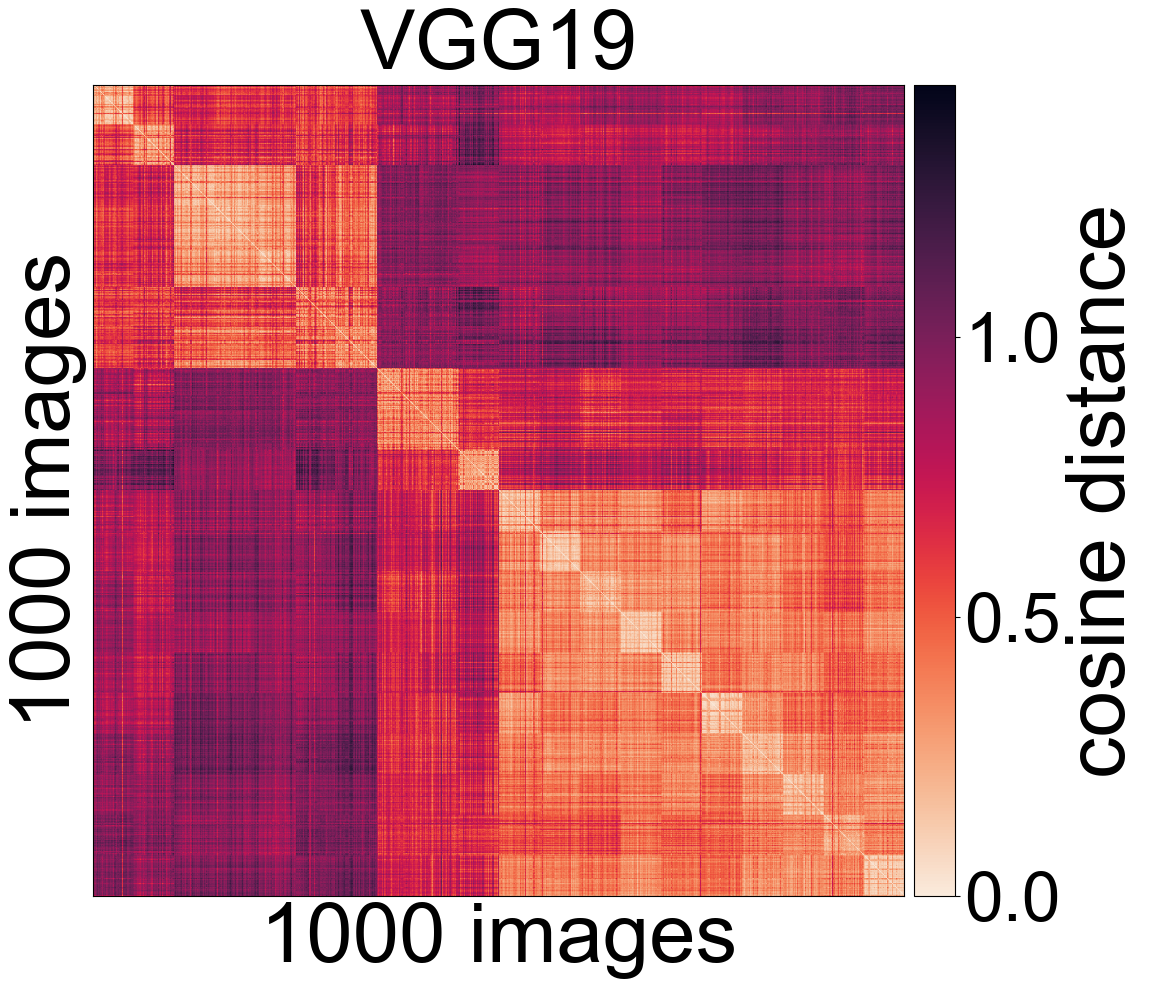

In [8]:
sim_mat_format = "sorted" # "sorted" : the rows and columns of the OT plans are sorted by the coarce categories. If there is no need for sorting, set it to "default".
visualize_config = VisualizationConfig(
    show_figure = True,
    fig_ext='svg',
    figsize=(12, 12), 
    title_size = 60, 
    cmap = 'rocket_r',
    font='Arial',
    
    xlabel = '1000 images',
    ylabel = '1000 images',
    cbar_label = 'cosine distance',
    cbar_label_size=60,
    
    xlabel_size=60,
    ylabel_size=60,
    
    cbar_ticks_size=50,
    
    ticks=None,
    ot_object_tick=False,
    ot_category_tick=False,
    
    # Note that please set ot_category_tick = True when drawing the category line.
    draw_category_line=False,
    category_line_color='black',
    category_line_alpha=0.5,
    category_line_style='dashed',
    plot_eps_log = eps_log,
    lim_acc=[0, 100], 
)

visualize_hist = VisualizationConfig(figsize=(8, 6), color='C0')

sim_mat = align_representation.show_sim_mat(
    sim_mat_format=sim_mat_format, 
    visualization_config=visualize_config,
    visualization_config_hist=visualize_hist,
    fig_dir=None,
    show_distribution=False,
)

## Reperesentation Similarity Aanalysis (RSA)
This performs a conventional representation similarity analysis.

In [9]:
### parameters for computing RSA
# metric = "pearson" or "spearman" by scipy.stats
# The result of RSA for each pair will be stored in align_representation.RSA_corr
align_representation.RSA_get_corr(metric="pearson")

# print(align_representation.RSA_corr)

Correlation ResNet50 vs VGG19 : 0.9139176696566598


## GWOT
The optimization results are saved in the folder named "config.data_name" + "representations.name" vs "representation.name".  
If you want to change the name of the saved folder, please make changes to "config.data_name" and "representations.name" (or change the "filename" in the code block below).

fix init mat random seed: False


  0%|          | 0/1 [00:00<?, ?it/s]

/home/masaru-sasaki/.pyenv/versions/mambaforge-23.11.0-0/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:747: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
[I 2024-10-23 15:26:20,453] Trial 4 finished with value: 0.015829102997380325 and parameters: {'eps': 0.0005611516415334506}. Best is trial 4 with value: 0.015829102997380325.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:26:37,855] Trial 5 finished with value: 0.02757945631371507 and parameters: {'eps': 0.007969454818643935}. Best is trial 4 with value: 0.015829102997380325.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:26:51,279] Trial 6 finished with value: 0.01961315125233566 and parameters: {'eps': 0.0029106359131330704}. Best is trial 4 with value: 0.015829102997380325.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:27:04,832] Trial 7 finished with value: 0.017188159096371884 and parameters: {'eps': 0.0015751320499779737}. Best is trial 4 with value: 0.015829102997380325.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:27:50,572] Trial 8 finished with value: 0.012941467746111941 and parameters: {'eps': 0.0002051338263087451}. Best is trial 8 with value: 0.012941467746111941.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:28:31,860] Trial 9 finished with value: 0.012942990227044383 and parameters: {'eps': 0.00020511104188433984}. Best is trial 8 with value: 0.012941467746111941.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:29:40,218] Trial 10 finished with value: 0.011657906828090956 and parameters: {'eps': 0.00013066739238053285}. Best is trial 10 with value: 0.011657906828090956.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:30:06,429] Trial 11 finished with value: 0.024196039051610066 and parameters: {'eps': 0.005399484409787433}. Best is trial 10 with value: 0.011657906828090956.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:30:19,934] Trial 12 finished with value: 0.017218540009120806 and parameters: {'eps': 0.0015930522616241021}. Best is trial 10 with value: 0.011657906828090956.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:30:33,415] Trial 13 finished with value: 0.019039161985261156 and parameters: {'eps': 0.0026070247583707684}. Best is trial 10 with value: 0.011657906828090956.


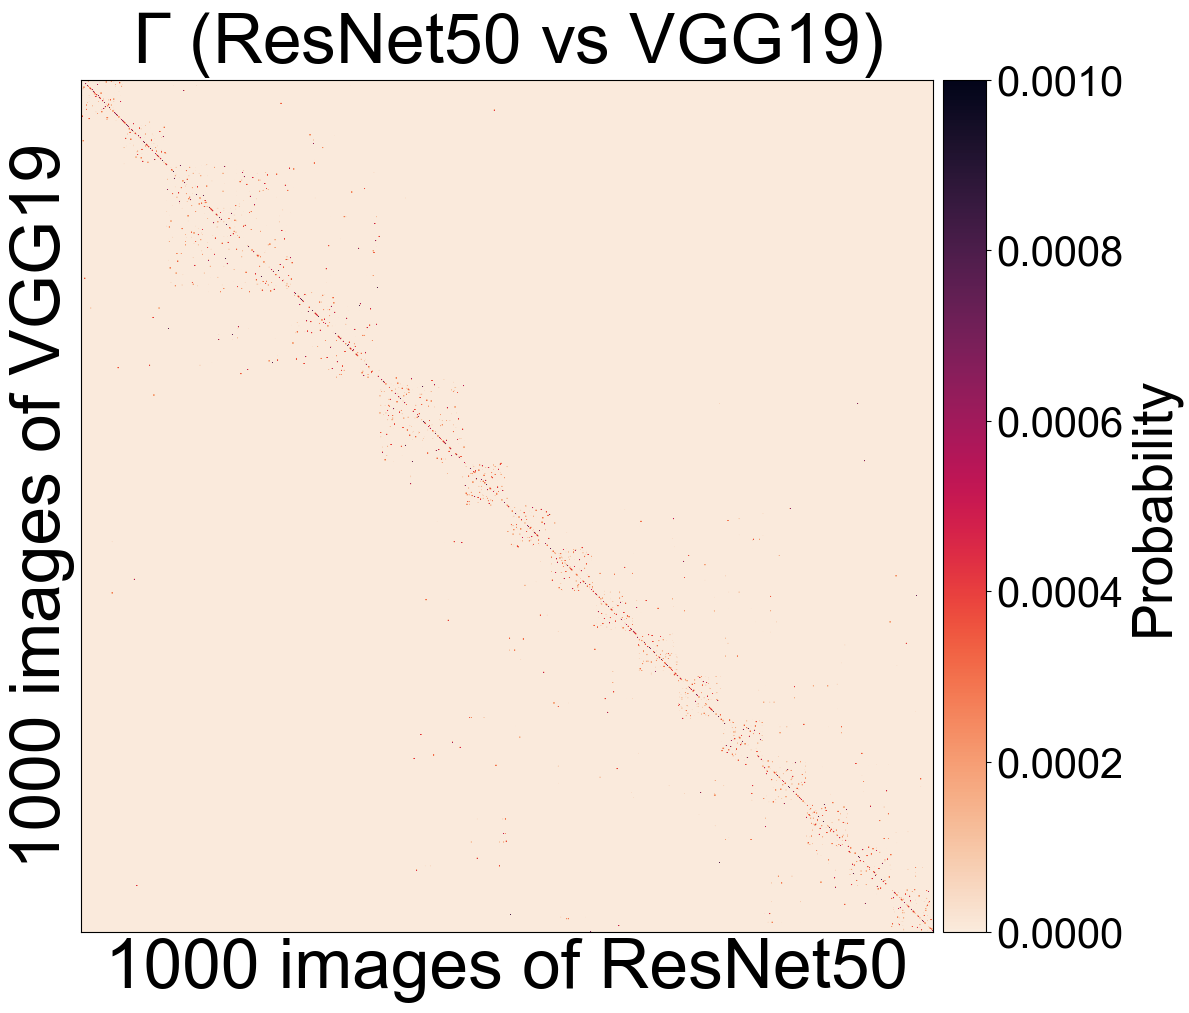

In [10]:
visualize_config.set_params(
    figsize=(12, 12), 
    title_size = 50,
    xlabel = '1000 images of ResNet50',
    ylabel = '1000 images of VGG19',
    font='Arial',
    cbar_label='Probability',
    cbar_label_size=40,
    cbar_ticks_size=30,
    
    xlabel_size=50,
    ylabel_size=50,
    
)

align_representation.gw_alignment(
    compute_OT = True,
    delete_results = False,
    
    ## return_data : If True, the "OT_format" data will be returned in `ot_list`.
    return_data = False,
    
    ## return_figure : If True, figure of OT will be shown in this notebook. Figure is always saved in the "figure" folder.
    return_figure = True,
    
    OT_format = sim_mat_format,
    visualization_config = visualize_config,
    
    ## save_dataframe : if True, you can save all the computed data stored in SQlite or PyMySQL in csv format (pandas.DataFrame) in the result folder.
    save_dataframe=True,
    change_sampler_seed=True, 
    sampler_seed = 42, 
    
    ## parallel_method : user can change the way of parallel computation, "multiprocess" or "multithread".
    # "multithread" may be effective for most case, please choose the best one for user's environment.
    parallel_method="multiprocess",
    
    ### caution!! : If your data are loaded from GPU when using torch.load() before computing `gw_alignment`, the multiprocessing may not work properly.
    ## You can solve this problem by saving the your data in CPU, like torch.save('your_data'.to("cpu")).
)

# Step 4: Evaluation and Visualization
Finally, you can evaluate and visualize the unsupervise alignment of GWOT.   

## Show how the GWD was optimized
`show_optimization_log` will make two figures to show both the relationships between epsilons (x-axis) and GWD (y-axis), and between accuracy (x-axis) and GWD (y-axis).



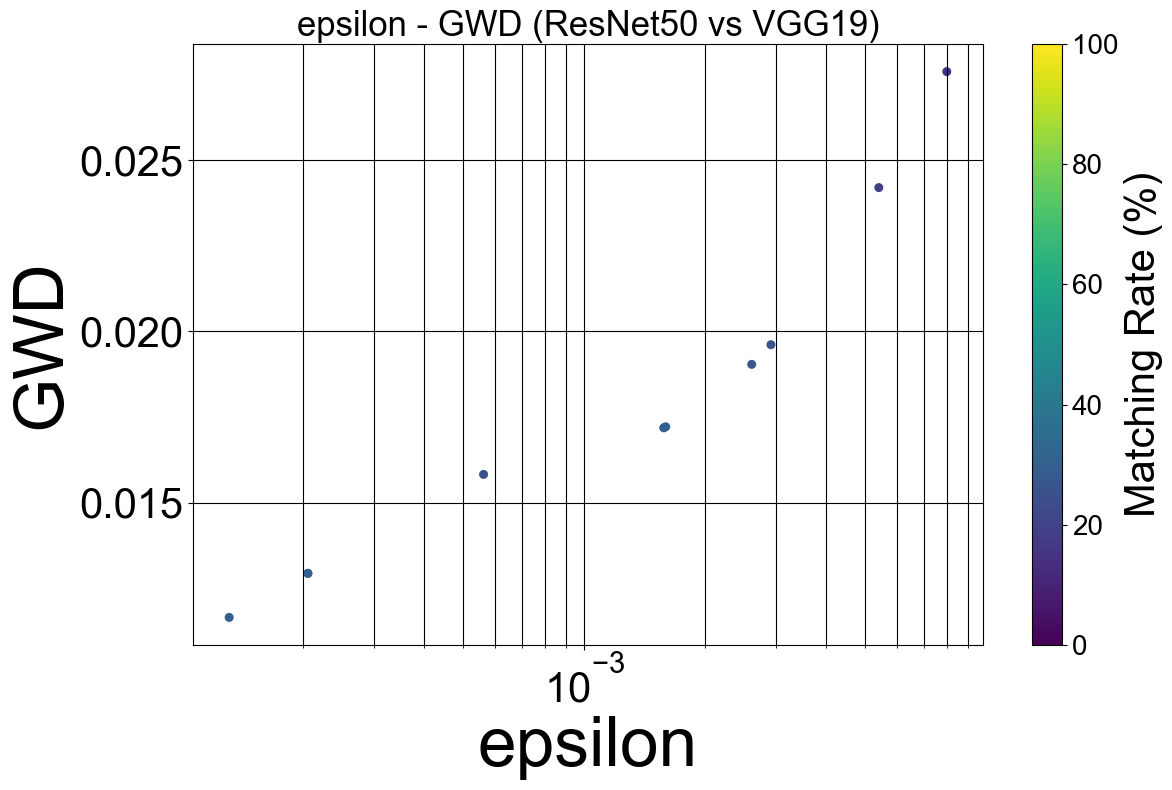

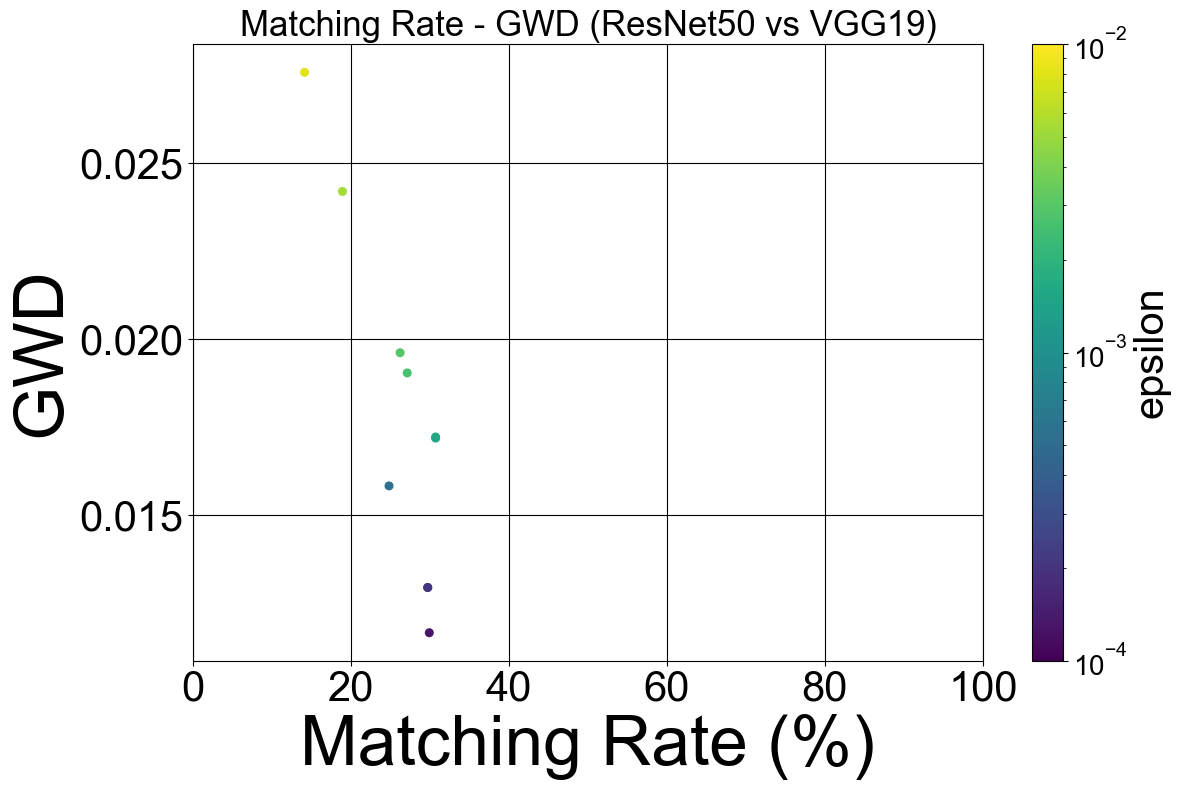

In [11]:
visualize_config.set_params(
    figsize=(12, 8),
    cmap = 'viridis',
    font='Arial',
    xticks_rotation=0,
    cbar_label_size=30,
    cbar_ticks_size=20,
    title_size=25,
    xticks_size=30,
    yticks_size=30,
    
)

align_representation.show_optimization_log(visualization_config=visualize_config) 

## Evaluation of the accuracy of the unsupervised alignment
There are two ways to evaluate the accuracy.  
1. Calculate the accuracy based on the OT plan.  
For using this method, please set the parameter `eval_type = "ot_plan"` in "calc_accuracy()".   
  
2. Calculate the matching rate based on the k-nearest neighbors of the embeddings.   
For using this method, please set the parameter `eval_type = "k_nearest"` in "calc_accuracy()".   

For both cases, the accuracy evaluation criterion can be adjusted by setting `top_k_list`.  

Top k accuracy : 
        ResNet50_vs_VGG19
top_n                   
1                   29.9
5                   59.0
10                  73.5

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


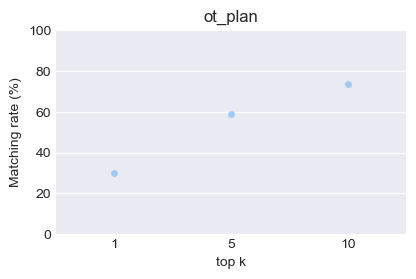

In [12]:
## Calculate the accuracy based on the OT plan. 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

K nearest matching rate : 
        ResNet50_vs_VGG19
top_n                   
1                   48.2
5                   79.0
10                  88.6

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


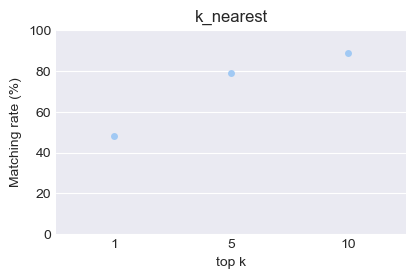

In [13]:
## Calculate the matching rate based on the k-nearest neighbors of the embeddings.
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

category level accuracy : 
        ResNet50_vs_VGG19
top_n                   
1                   77.5
5                   94.9
10                  98.5

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


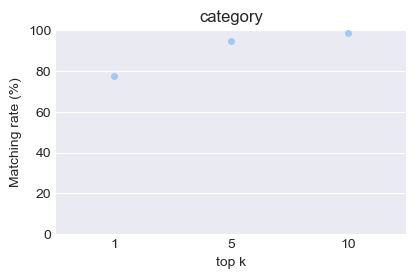

In [14]:
## Calclate the category level accuracy
# If the data has the coarse category labels, you can observe the category level accuracy.
# This accuracy is calculated based on the OT plan.
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "category", category_mat=category_mat)
align_representation.plot_accuracy(eval_type = "category", scatter = True)


## Procrustes Analysis
Using optimized transportation plans, you can align the embeddings of each representation to a shared space in an unsupervised manner.  
The `"pivot"` refers to the target embeddings space to which the other embeddings will be aligned.   
You have the option to designate the `"pivot"` as one of the representations or the barycenter.  
Please ensure that 'pair_number_list' includes all pairs between the pivot and the other Representations.  

If you wish to utilize the barycenter, please make use of the method `AlignRepresentation.barycenter_alignment()`.  
You can use it in the same manner as you did with `AlignRepresentation.gw_alignment()`.

For here, we use the embeddings for the 6 categories below.

In [15]:
### define the category info from label data in the validation dataset.
lab_path = '../../data/DNN/label.pt'
lab = torch.load(lab_path).to('cpu').numpy()

### category_mat needs to be an one-hot encoding. 
category_mat = pd.get_dummies(lab)

category_mat.columns = np.load('../../data/DNN/label_name.npy')

category_name_list = ['tiger', 'indigo', 'electric', 'house', 'cock']

object_labels, category_idx_list, num_category_list, category_name_list = get_category_data(category_mat, category_name_list)  


/tmp/ipykernel_689218/1132663515.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lab = torch.load(lab_path).to('cpu').numpy()


In [16]:
category_mat.columns

Index(['tench', 'goldfish', 'great', 'tiger', 'hammerhead', 'electric',
       'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house',
       'junco', 'indigo', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee'],
      dtype='object')

New category information is given.


/home/masaru-sasaki/work_space/GWTune/scripts/tutorial_other_datasets/../../src/utils/visualize_functions.py:454: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


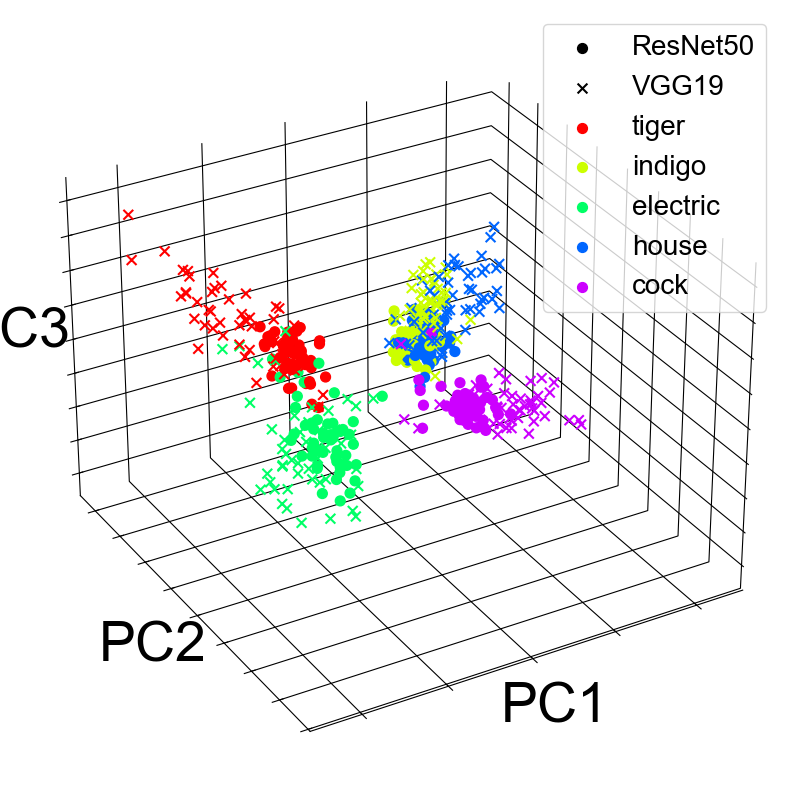

In [17]:
emb_name = "PCA" #"TSNE", "PCA", "MDS"
dim = 3
visualization_embedding = VisualizationConfig(
    fig_ext='svg',
    font='Arial',
    figsize=(10, 10), 
    xlabel="PC1",
    ylabel="PC2", 
    zlabel="PC3",
    marker_size=50,
    xlabel_size=40,
    ylabel_size=40,
    zlabel_size=40,
    legend_size=20,
)

align_representation.visualize_embedding(
    dim=dim,
    method=emb_name,
    pivot=0,
    visualization_config=visualization_embedding,
    category_name_list=category_name_list, 
    category_idx_list=category_idx_list, 
    num_category_list=num_category_list,
)

## (Option) Visualize the aligned embeddings
It is helpful to visually inspect the quality of the unsupervised alignment by plotting the aligned embeddings in 2D or 3D space. 


Using the optimal transportation plan $\Gamma∗$, one set of embeddings $X$, 
and the other set of aligned embeddings are obtained by performing matrix product of the $\Gamma*$ and $X$. 

This $\Gamma* X$ means the new embedding to represent the other set of embedding $Y$ in the space of $X$. 

Next, the embedding of $X$ and new embedding of $Y$ ($Γ∗X$) in the space of $X$ are concatenated in the axis of the number of embeddings (e.g. experimental stimuli, and so on).  
Then, for example, Principle Components Analysis (PCA) is used to project high-dimensional embeddings into 2D or 3D space, but other dimensionality reduction methods are also applicable. 

And, each one of the two embeddings were plotted in 3D figure after splitting the data into the two embeddings. 
If there is a known correspondence between the embeddings, the user can visually check whether the aligned embeddings are positioned close to the corresponding embeddings.

In [18]:
pair = align_representation.pairwise_list[0]

ot = pair.OT

# plt.imshow(ot, cmap='viridis')
# plt.show()

In [19]:
source = pair.source.embedding
target = pair.target.embedding

new_source = pair.OT.T @ target * len(target)
new_target = pair.OT @ source * len(source)


In [20]:
new_rep_list = [
    Representation(name="ResNet50", embedding=source),
    Representation(name="VGG19", embedding=new_target),
]

ar = AlignRepresentations(
    config=config,
    representations_list=new_rep_list,
    histogram_matching=False,
    metric="cosine",
    main_results_dir="../../results/" + data_select,
    data_name=data_select,
)

data_name : DNN
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: ResNet50_vs_VGG19 eps_list: [0.0001, 0.01]


New category information is given.


/home/masaru-sasaki/work_space/GWTune/scripts/tutorial_other_datasets/../../src/utils/visualize_functions.py:454: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


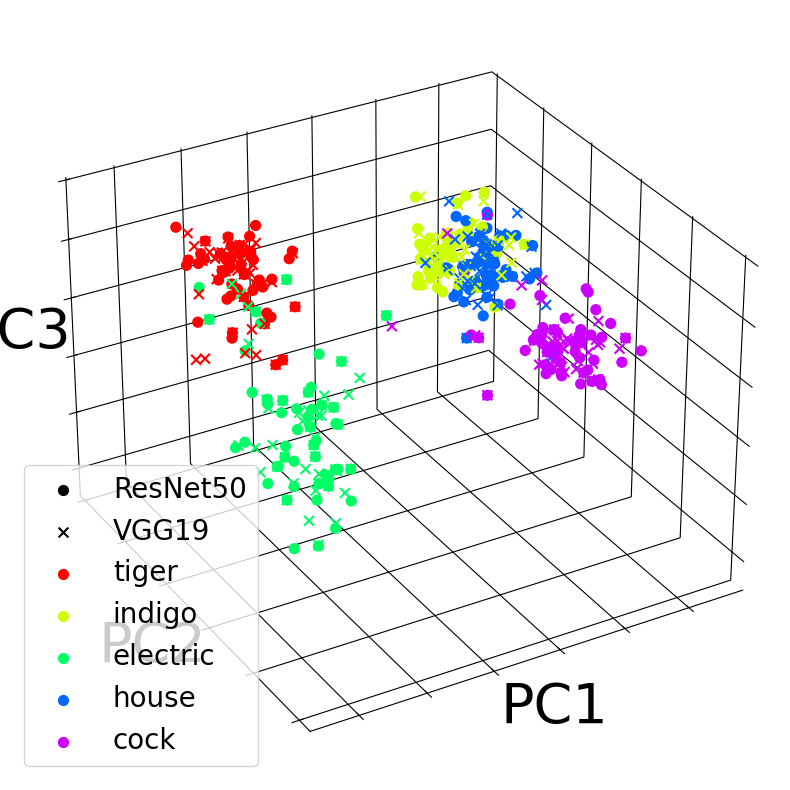

In [21]:
emb_name = "PCA" #"TSNE", "PCA", "MDS"
dim = 3
visualization_embedding = VisualizationConfig(
    fig_ext='svg',
    figsize=(10, 10), 
    xlabel="PC1",
    ylabel="PC2", 
    zlabel="PC3",
    marker_size=50,
    xlabel_size=40,
    ylabel_size=40,
    zlabel_size=40,
    legend_size=20,
)

ar.visualize_embedding(
    dim=dim,
    method=emb_name,
    pivot=None,
    visualization_config=visualization_embedding,
    category_name_list=category_name_list, 
    category_idx_list=category_idx_list, 
    num_category_list=num_category_list,
)